## Step 1: Load the trained model

In [2]:
import torch
from GNN_model import VesselGNN

checkpoint = torch.load("best_vessel_gnn.pth", map_location="cpu")

model = VesselGNN()
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model loaded from epoch:", checkpoint["epoch"])


e:\GNN_model\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded from epoch: 91


## Step 2: Prepare New Patient Data

In [3]:
import pandas as pd
import torch
from torch_geometric.data import Data

df = pd.read_csv("data/centerlines_c0014.csv")

# Node features
x = torch.tensor(df[['X', 'Y', 'Z', 'MaximumInscribedSphereRadius']].values,
                 dtype=torch.float)

# Build edges 
edge_index = []
for i in range(len(df) - 1):
    edge_index.append([i, i+1])
    edge_index.append([i+1, i])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

new_patient_data = Data(x=x, edge_index=edge_index)


## Step 3: Predict Blood Flow

In [4]:
with torch.no_grad():
    prediction = model(new_patient_data)
    
prediction.shape


torch.Size([5329, 16])

## Step 4: Save to csv file

In [5]:
pred_values = prediction.squeeze().numpy()
print(pred_values[:,0])

csv_output = pd.DataFrame({
    'NodeIndex': range(len(pred_values)),
    'PredictedRiskScore': pred_values[:,0]
})
csv_output.to_csv("predicted_risk_scores_c0014.csv", index=False)

[1.6712052  1.9637129  1.8981111  ... 0.48009652 0.49907458 0.44217938]


## Step 5: Visualization

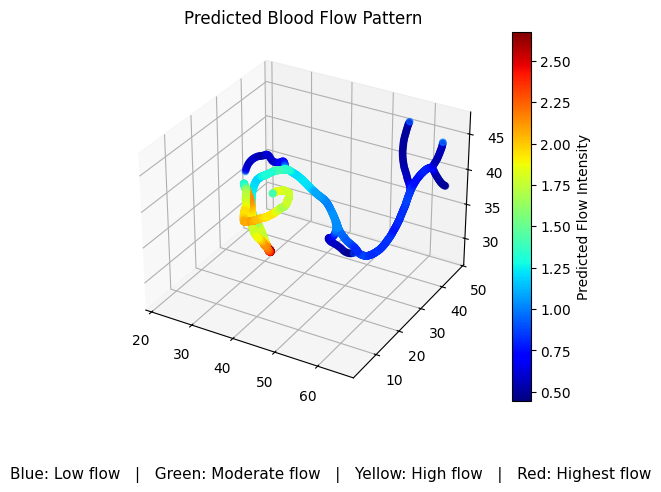

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = new_patient_data.x.numpy()   # geometry
flow = pred_values[:, 0]             # prediction

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    x[:,0], x[:,1], x[:,2],
    c=flow,
    cmap='jet'
)

fig.text(
    0.5, -0.05,
    "Blue: Low flow   |   Green: Moderate flow   |   Yellow: High flow   |   Red: Highest flow",
    ha="center",
    fontsize=11
)

plt.colorbar(sc, label="Predicted Flow Intensity")
ax.set_title("Predicted Blood Flow Pattern")
plt.show()
